1.) Preparación del Environment, dependencias, e importación de modulos.

In [1]:
#Instalamos las librerias base a nuestro proyecto-environment.
#pip install numpy pandas matplotlib seaborn xgboost scikit-learn
#!pip install scikit-learn

In [2]:

# Guardamos las dependencias actuales del entorno en el archivo requirements.txt.
# Si se instalan nuevas librerías más adelante, se debe volver a ejecutar este comando para actualizar el archivo.
# Esto permite que otros usuarios puedan replicar el entorno con: pip install -r requirements.txt
#!pip freeze > requirements.txt



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

2.) Lectura de los datos. En este caso, se trata de un dataset de consumo energético a lo largo de los años, según la AEP. (American Electric Power.) 

In [4]:
df = pd.read_csv('AEP_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


In [5]:
df.describe

<bound method NDFrame.describe of                       AEP_MW
Datetime                    
2004-12-31 01:00:00  13478.0
2004-12-31 02:00:00  12865.0
2004-12-31 03:00:00  12577.0
2004-12-31 04:00:00  12517.0
2004-12-31 05:00:00  12670.0
...                      ...
2018-01-01 20:00:00  21089.0
2018-01-01 21:00:00  20999.0
2018-01-01 22:00:00  20820.0
2018-01-01 23:00:00  20415.0
2018-01-02 00:00:00  19993.0

[121273 rows x 1 columns]>

In [6]:

# Verificar si el índice está ordenado
print(df.index.is_monotonic_increasing)

# Verificar duplicados en el índice
print(df.index.duplicated().sum())

# Ordenar el índice si es necesario
df = df.sort_index()

False
4


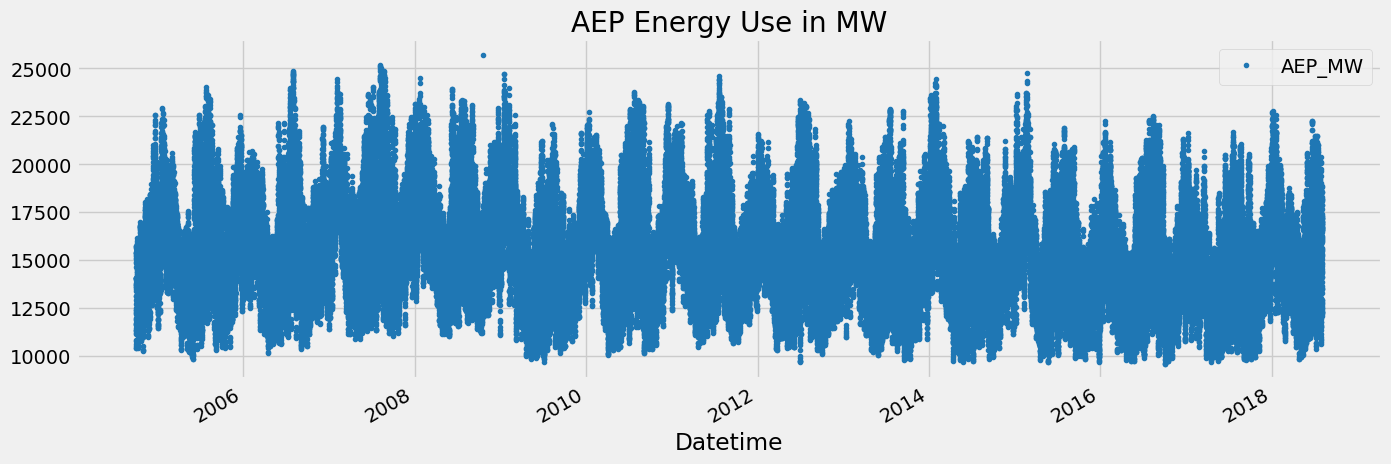

In [7]:
#Un pequeño gráfico para la previsualización de los datos y observar su distribución.
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='AEP Energy Use in MW')
plt.show()

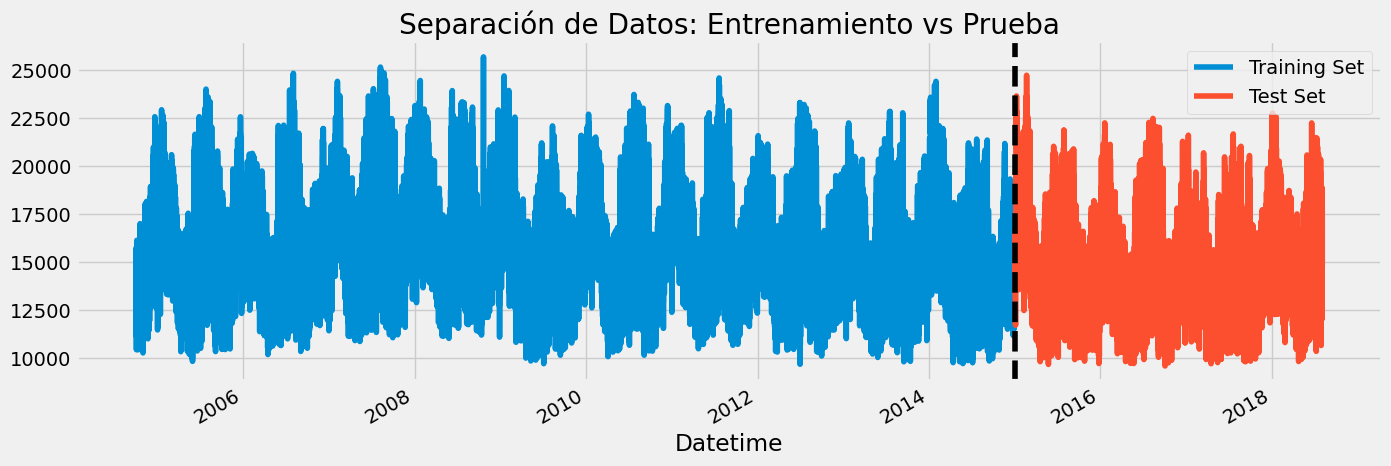

In [8]:

# Visualización de la distribución temporal de los datos de entrenamiento y prueba.
# El conjunto de datos abarca un periodo de 14 años, de los cuales aproximadamente el 20% (3 años)
# se reserva para pruebas, comenzando desde el 1 de enero de 2015.

# División del DataFrame en conjuntos de entrenamiento y prueba
train = df.loc[df.index < '2015-01-01']
test = df.loc[df.index >= '2015-01-01']

# Creación de la figura para la visualización
fig, ax = plt.subplots(figsize=(15, 5))

# Graficar ambos conjuntos
train.plot(ax=ax, label='Conjunto de Entrenamiento', title='Separación de Datos: Entrenamiento vs Prueba')
test.plot(ax=ax, label='Conjunto de Prueba')

# Línea divisoria que marca el inicio del conjunto de prueba
ax.axvline('2015-01-01', color='black', linestyle='--')

# Leyenda y despliegue de la gráfica
ax.legend(['Training Set', 'Test Set'])
plt.show()


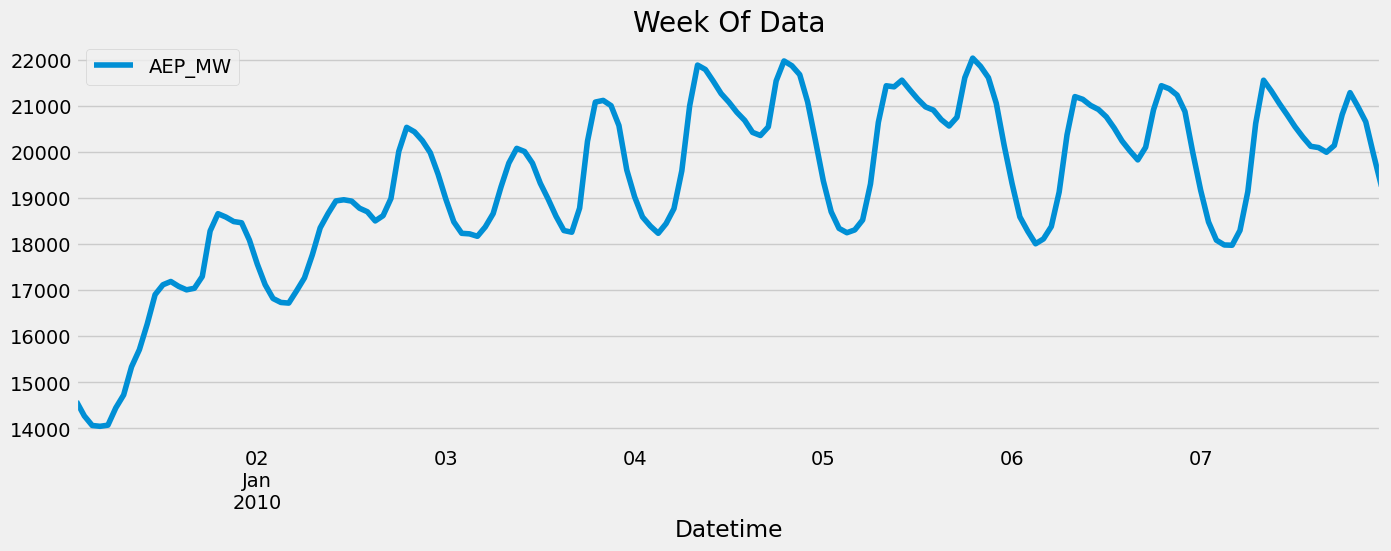

In [9]:

# Visualización de un fragmento semanal de los datos.
# Este gráfico permite observar el comportamiento detallado de la serie temporal 
# durante una semana específica (del 1 al 8 de enero de 2010), facilitando el análisis a corto plazo.
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()


In [10]:

def create_features(df):
    """
    Genera variables temporales a partir del índice de fechas del DataFrame.
    Estas características son útiles para modelos de series de tiempo, ya que capturan patrones
    estacionales y cíclicos relacionados con la hora, el día, el mes, etc.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week

    return df


df = create_features(df)

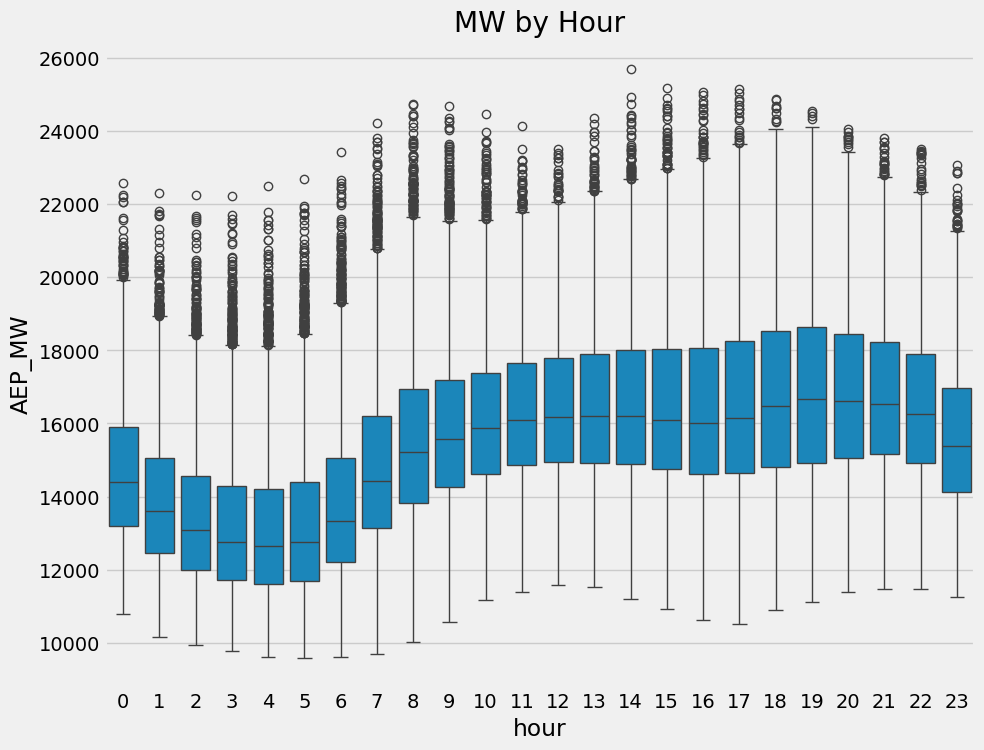

In [11]:
#visualizar cómo varía la demanda de energía 
#(en megavatios, MW) a lo largo de las horas del día:

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='AEP_MW')
ax.set_title('MW by Hour')
plt.show()

El grafico nos muestra entonces, una mediana (línea central).
los cuartiles (caja), los rangos típicos (bigotes) y los valores atípicos (puntos fuera de los bigotes).

Es útil para identificar las horas con mayor variabilidad en la demanda de la energía, determinar las horas pico de consumo y los comportamientos anómalos.

C:\Users\NKD\AppData\Local\Temp\ipykernel_8384\1824668288.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y='AEP_MW', palette='Blues')


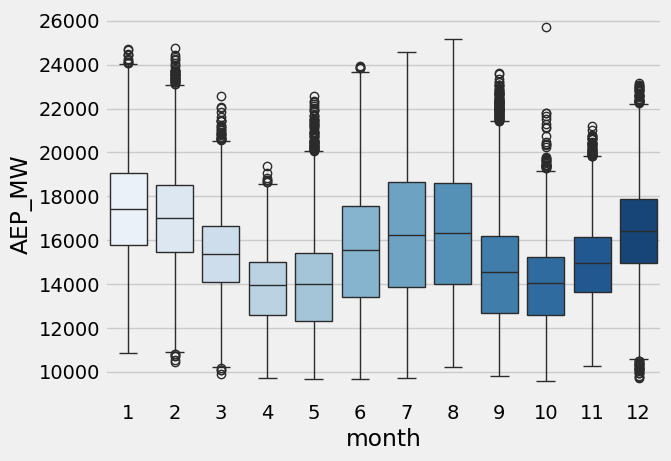

In [12]:
#Aquí podremos ver una visualización mensual de la información.
# fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='AEP_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

C:\Users\NKD\AppData\Local\Temp\ipykernel_8384\1506876030.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='year', y='AEP_MW', palette='Blues')


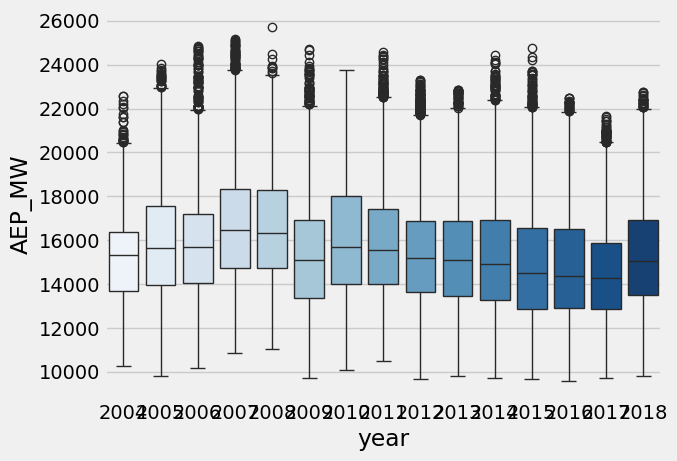

In [13]:
#Esta, una visualización anual.
# fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='year', y='AEP_MW', palette='Blues')
ax.set_title('MW by year')
plt.show()

La visualización del consumo periódico de energía es una herramienta clave para extraer patrones útiles que pueden guiar la toma de decisiones en sectores como compañías aseguradoras, eléctricas y otras entidades involucradas en la cadena de distribución.

Además, este análisis visual es fundamental para el desarrollo de modelos predictivos, ya que permite identificar comportamientos recurrentes y estacionales en los datos, lo cual mejora la precisión de los algoritmos de predicción.

3. Creación del Modelo de Predicción.

In [14]:

# A partir de nuestros conjuntos previamente divididos (train y test),
# generamos nuevas características basadas en componentes temporales.
# Estas variables ayudan a capturar patrones estacionales y cíclicos en las series de tiempo.


train = create_features(train)
test = create_features(test)

# Definimos las características (features) que usaremos para entrenar el modelo

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'AEP_MW'

# Separamos los datos en variables independientes (X) y variable objetivo (y)

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [15]:

# Configuramos los hiperparámetros del modelo de regresión XGBoost.
# Este modelo es eficaz para tareas de predicción en series de tiempo.


reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)


# Entrenamos el modelo con los datos de entrenamiento y validamos con los datos de prueba.
# El parámetro 'eval_set' permite monitorear el rendimiento durante el entrenamiento.

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:15793.26088	validation_1-rmse:14861.30012
[100]	validation_0-rmse:6033.92025	validation_1-rmse:5144.77002


c:\Users\NKD\Desktop\CIENTIFICO DE DATOS, JAIME JANER\PROYECTOS\energy_consumption\venv\Lib\site-packages\xgboost\callback.py:386: UserWarning: [14:35:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[200]	validation_0-rmse:2703.71020	validation_1-rmse:2159.54200
[300]	validation_0-rmse:1754.92809	validation_1-rmse:1667.43143
[393]	validation_0-rmse:1525.95027	validation_1-rmse:1657.89627


,objective,'reg:linear'
,base_score,0.5
,booster,'gbtree'
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,None


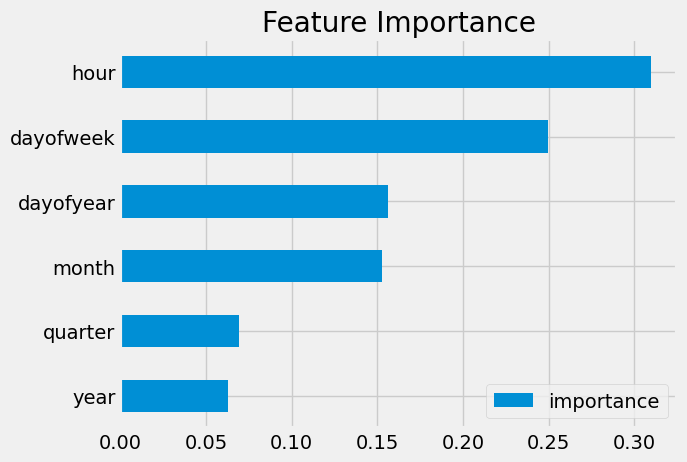

In [16]:
# Visualizamos la importancia de cada característica en el modelo entrenado.
# Esto nos permite identificar cuáles variables temporales tienen mayor influencia
# en la predicción de la demanda energética (AEP_MW).


fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])

# Ordenamos las características por importancia y generamos un gráfico de barras horizontal.

fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

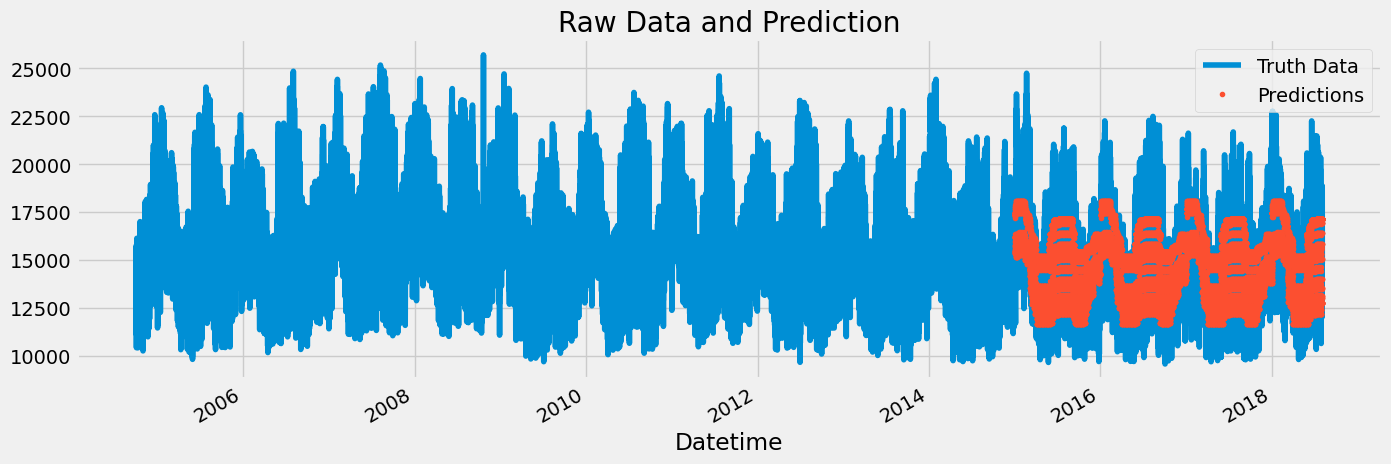

In [17]:

#Generamos predicciones sobre el conjunto de prueba y las agregamos al DataFrame original.

test['prediction'] = reg.predict(X_test)

#Unimos las predicciones al DataFrame original para facilitar la visualización.
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

# Visualizamos los datos reales frente a las predicciones del modelo.
ax = df[['AEP_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

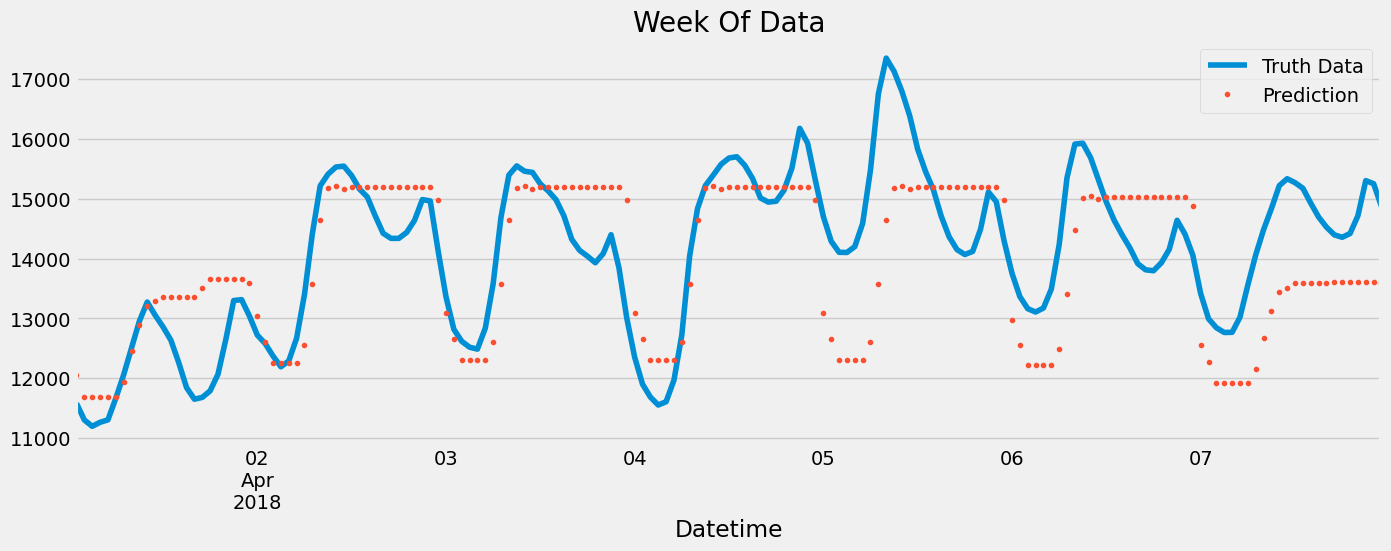

In [18]:

# Visualizamos una semana específica de datos reales y predicciones del modelo.
# Esto permite evaluar el rendimiento del modelo en un intervalo de tiempo concreto.

ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['AEP_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [19]:

# Calculamos el error cuadrático medio (RMSE) entre los valores reales y las predicciones.
# Esta métrica nos indica qué tan lejos están, en promedio, las predicciones del modelo respecto a los datos reales.

score = np.sqrt(mean_squared_error(test['AEP_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:.2f}')

RMSE Score on Test set: 1649.42


In [20]:

# Calculamos el error absoluto entre los valores reales y las predicciones.
test['error'] = np.abs(test[TARGET] - test['prediction'])

# Extraemos solo la fecha (sin hora) del índice para agrupar por día.
test['date'] = test.index.date

# Calculamos el error absoluto medio por día y mostramos los 10 días con mayor error.
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2015-02-19    5630.352132
2015-02-20    5394.673665
2018-01-06    4823.354574
2015-01-08    4703.830404
2015-12-25    4415.192912
2015-02-16    4411.147461
2015-12-24    4138.202759
2015-02-15    4079.741536
2018-01-05    4044.314657
2018-01-07    4037.638062
Name: error, dtype: float64

In [21]:

from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import numpy as np

# MAE: Error absoluto medio
mae = mean_absolute_error(test['AEP_MW'], test['prediction'])

# R²: Coeficiente de determinación
r2 = r2_score(test['AEP_MW'], test['prediction'])

# RMSE: Raíz del error cuadrático medio
rmse = np.sqrt(mean_squared_error(test['AEP_MW'], test['prediction']))

# MAPE: Error porcentual absoluto medio
mape = np.mean(np.abs((test['AEP_MW'] - test['prediction']) / test['AEP_MW'])) * 100

# Mostrar resultados
print(f"MAE (Error Absoluto Medio): {mae:.2f}")
print(f"R² (Coeficiente de Determinación): {r2:.4f}")
print(f"RMSE (Raíz del Error Cuadrático Medio): {rmse:.2f}")
print(f"MAPE (Error Porcentual Absoluto Medio): {mape:.2f}%")


MAE (Error Absoluto Medio): 1319.00
R² (Coeficiente de Determinación): 0.5704
RMSE (Raíz del Error Cuadrático Medio): 1649.42
MAPE (Error Porcentual Absoluto Medio): 8.95%


MAE (Error Absoluto Medio)	1319.00	En promedio, el modelo se equivoca por 1319 MW. Es una medida directa del error sin penalizar grandes desviaciones.
RMSE (Raíz del Error Cuadrático Medio)	1649.42	Similar al MAE, pero penaliza más los errores grandes. Esto indica que hay algunos errores más altos que elevan el promedio.
R² (Coeficiente de Determinación)	0.5704	El modelo explica aproximadamente el 57% de la variabilidad de la demanda energética. Es un resultado moderado, pero con margen de mejora.
MAPE (Error Porcentual Absoluto Medio)	8.95%	En promedio, las predicciones se desvían un 8.95% del valor real. Un MAPE menor al 10% suele considerarse aceptable en muchos contextos.